## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [1]:
###########################################################################################

In [2]:
#Importing Packages
import pylab as pl
import pandas as pd
import os
import json
import numpy as np
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!curl -O https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/Ridetypes.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12802  100 12802    0     0  12802      0  0:00:01 --:--:--  0:00:01  162k


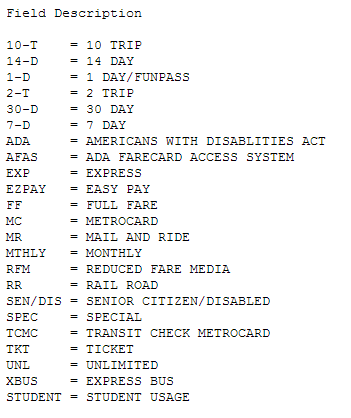

In [4]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [5]:
#loading in data
!wget https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy

--2017-12-09 19:15:20--  https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy
Resolving raw.githubusercontent.com... 151.101.20.133
Connecting to raw.githubusercontent.com|151.101.20.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10708880 (10M) [application/octet-stream]
Saving to: “MTA_Fare.npy.8”

100%[======================================>] 10,708,880  --.-K/s   in 0.1s    

2017-12-09 19:15:21 (75.1 MB/s) - “MTA_Fare.npy.8” saved [10708880/10708880]



In [6]:
#loading in MTA_Fare.npy
DIRTYdataMTA = np.load('MTA_Fare.npy')
DIRTYdataMTA.shape

(600, 23, 194)

In [7]:
#dataMTA cleaning
dataMTA = DIRTYdataMTA.astype(np.float)
np.place(dataMTA, dataMTA == -1, np.nan)

In [8]:
#flatten data cube all 600 stations
dataMTA_cardtype = np.nansum(dataMTA, axis =0)
dataMTA_station = np.nansum(dataMTA, axis = 1)

#"Flatten data cube 1 time, then flatten a second time
dataMTA_cardtype.shape, dataMTA_station.shape

((23, 194), (600, 194))

In [9]:
#set dates
dates = pd.date_range('5/21/2010', periods = 194, freq = 'W')

In [10]:
#Load ridetypes
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

print ridetype.shape
print ridetype

(23,)
['10t' '14d' '1d' '2t' '30d' '7d' 'ada' 'afas' 'exp' 'ez' 'ff' 'mc' 'mr'
 'month' 'rfm' 'rr' 'sen' 'spec' 'tcmc' 't' 'umlim' 'xbus' 'stud']


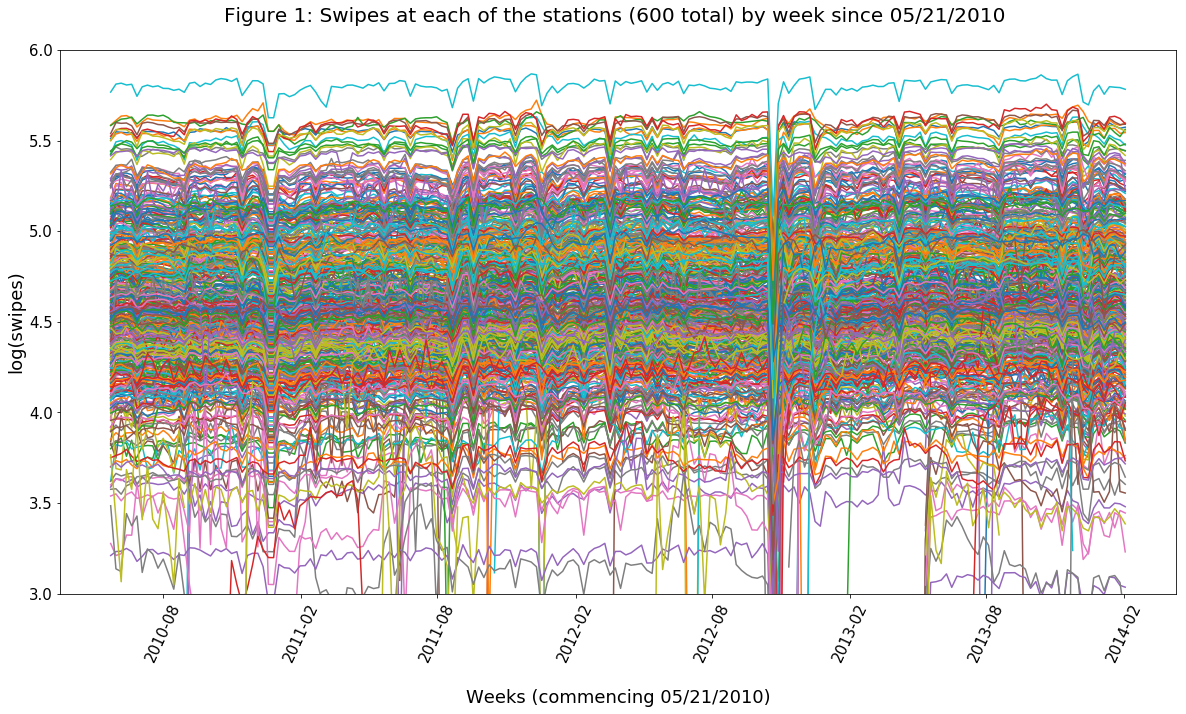

In [11]:
#plot all stations
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

for i in range(len(np.nansum(dataMTA_station,axis=1))):
    ax.plot(dates, np.log10(dataMTA_station [i]))

    
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 1: Swipes at each of the stations (600 total) by week since 05/21/2010 \n", fontsize=20)
pl.xticks(rotation='65', fontsize = 15)
pl.yticks(fontsize = 15)

ax.set_ylabel("log(swipes)", fontsize=18)
ax.set_xlabel("\nWeeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim(3,6)#0,100)1e4,1e6);
ax.set_xlim();

### Fig 1. Swipes for all 600 stations for 194 weeks

In [12]:
#flatting data cube over stations. Showing avg swipes per station per week
dataMTA_stationAVG = np.nanmean(dataMTA_station, axis = 0)

#identify the specific event by taking the mean and standard deviation
print ("mean swipes by week {:.2f}".format(np.nanmean(dataMTA_station)))
print ("stdev swipes by week {:.2f}".format(np.nanstd(dataMTA_station)))

mean swipes by week 49635.58
stdev swipes by week 69320.33


In [13]:
#define thresholds
thresholds = [np.nanmean(dataMTA_stationAVG) + 3 * np.nanstd(dataMTA_stationAVG), 
              np.nanmean(dataMTA_stationAVG) - 3 * np.nanstd(dataMTA_stationAVG)]

#print threshold range. ID earliest datapoint
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))
print ("earliest datapoint", min(dates))

3-sigma thresholds 64555.39 34715.78
('earliest datapoint', Timestamp('2010-05-23 00:00:00', offset='W-SUN'))


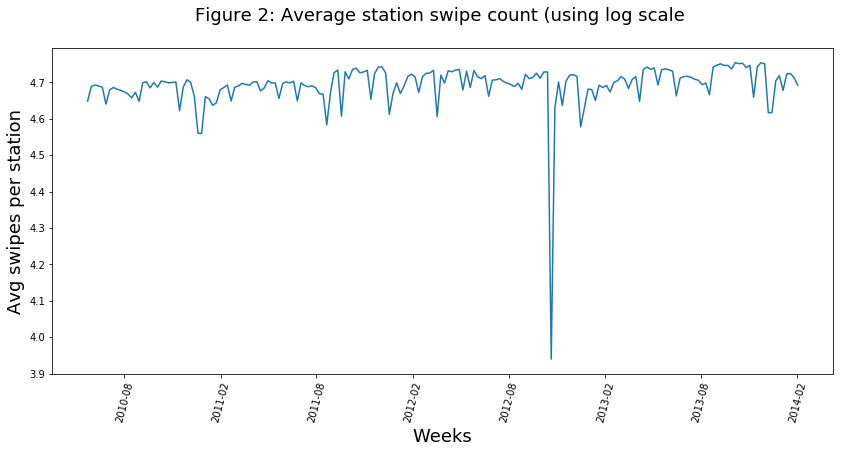

In [14]:
#flatting data cube over stations. Showing avg swipes per station per week
dataMTA_stationAVG = np.nanmean(dataMTA_station, axis = 0)
#ax = dataMTA_station.plot(logy=True, figsize=(10,5), style=".-", ms=20, color="IndianRed")

#Plot results
pl.figure(figsize=(14,6))
pl.xlabel('Weeks', fontsize = 18)
pl.ylabel('Avg swipes per station', fontsize = 18)
pl.title("Figure 2: Average station swipe count (using log scale \n", fontsize=18)
pl.xticks(rotation=75)

pl.plot(dates, np.log10(dataMTA_stationAVG))


### Fig 2. Average swipes per station

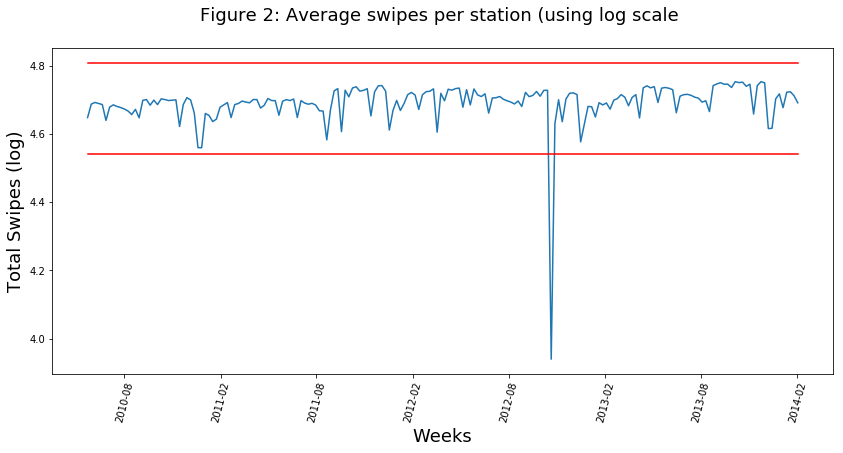

In [15]:
#Plot with threshold lines
pl.figure(figsize=(14,6))
pl.xlabel('Weeks', fontsize = 18)
pl.ylabel('Total Swipes (log)', fontsize = 18)
pl.title("Figure 2: Average swipes per station (using log scale \n", fontsize=18)
pl.xticks(rotation=75)

pl.plot(dates, np.log10(dataMTA_stationAVG))


#Plot Lower Threshold
pl.plot((min(dates), max(dates)),(np.log10(thresholds[1]),np.log10(thresholds[1])), color='r',
       label='Lower thresholtd for event detection (log10) = %.2f' % np.log10(thresholds[1]))

#Plot Upper Threshold
pl.plot((min(dates), max(dates)),(np.log10(thresholds[0]),np.log10(thresholds[0])), color='r',
       label='Upper thresholtd for event detection (log10) = %.2f' % np.log10(thresholds[1]))



### Fig 3. Average station swipe count (using log scale)

In [16]:
#ID outlier
WeekID = np.argmin(dataMTA_stationAVG)
print("The week number of the specific event is {}".format(WeekID) + 
      " which corresponds to the week {}".format(dates[WeekID]))

The week number of the specific event is 126 which corresponds to the week 2012-10-21 00:00:00


## Task 1 Conclusion:
#### Prominent event occurs during the week of 2012-10-21. This coincides with Hurricane Sandy.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)



In [17]:
print(dataMTA_cardtype.shape)

(23, 194)


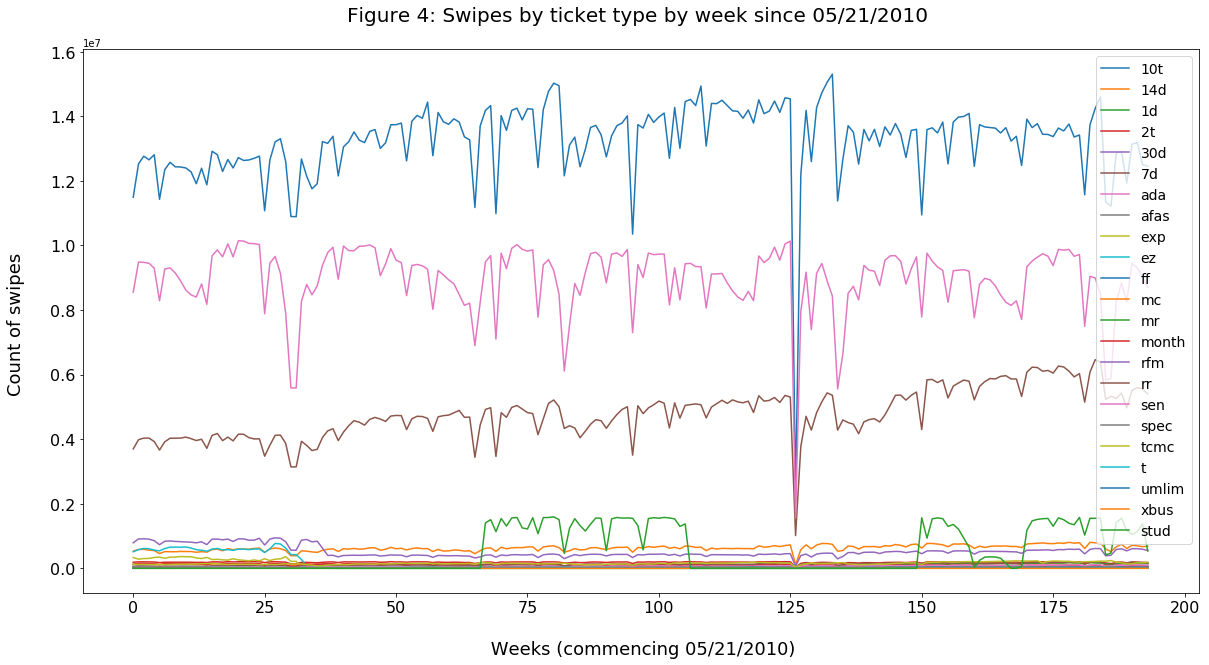

In [18]:
#Plot all Swipe data by cardtype
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

for i in range(len(dataMTA_cardtype)):
    plot(dataMTA_cardtype[i], label = ridetype[i] )
    
ax.tick_params(axis='both',labelsize=16)
pl.title("Figure 4: Swipes by ticket type by week since 05/21/2010 \n", fontsize=20)
ax.set_ylabel("Count of swipes \n", fontsize=18)
ax.set_xlabel("\n Weeks (commencing 05/21/2010)", fontsize=18)
ax.set_ylim()#3,60,100)1e4,1e6);
ax.set_xlim()#0,100)
plt.legend(fontsize=14);

### Fig. 5 Count of swipes for all cardtypes

In [19]:
#Convert dataMTA_cardtype_df convert from np.array to data frame & show shape
dataMTA_cardtype_df = pd.DataFrame(dataMTA_cardtype, index=ridetype ).T
dataMTA_cardtype_df.shape

(194, 23)

In [20]:
dataMTA_cardtype_df.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


In [21]:
#take mean for first 10 weeks and last 10 weeks
mta_rideType_start = pd.rolling_mean(dataMTA_cardtype_df, 10).iloc[9:19].apply(lambda x: np.mean(x))
mta_rideType_end = pd.rolling_mean(dataMTA_cardtype_df, 10).iloc[-10:].apply(lambda x: np.mean(x))


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  app.launch_new_instance()


In [22]:
#create ration
mta_rideType_ratio = mta_rideType_start/mta_rideType_end

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf913f6090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faf9179d050>]], dtype=object)

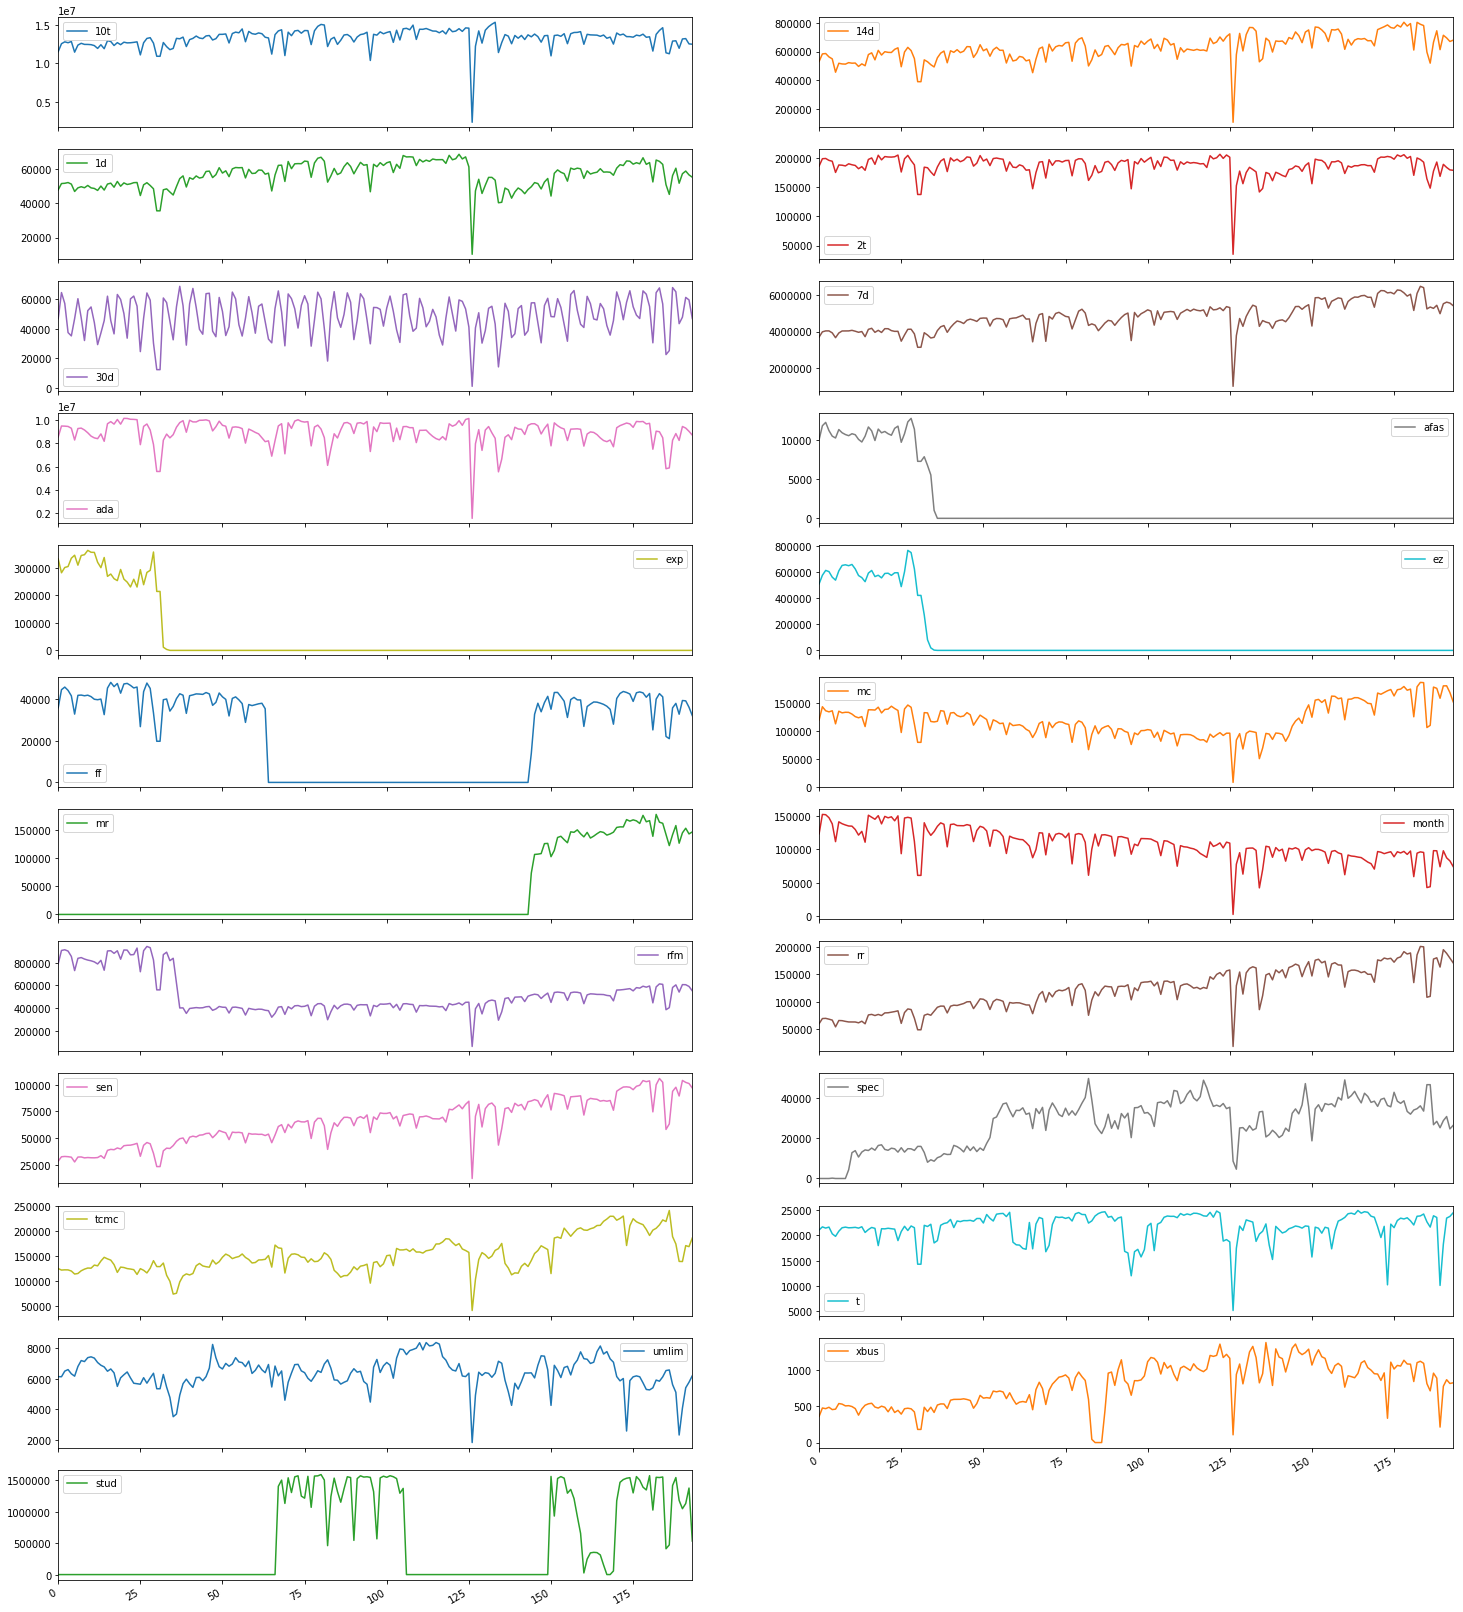

In [23]:
dataMTA_cardtype_df.plot(subplots= True, layout=(15,2), figsize=(25,40))


### Fig. 6 Individual swipe count for all 23 cardtypes.

In [24]:
#identify first and last 10 weeks for cardtype
first10weeks = dataMTA_cardtype_df[0:10]
last10weeks = dataMTA_cardtype_df[-10:]

In [25]:
#take means for first and last 
first10weeks_mean = first10weeks.mean(axis = 0)
last10weeks_mean = last10weeks.mean(axis = 0)

In [26]:
first10weeks_mean

10t      12347326.1
14d        533376.2
1d          49898.9
2t         190627.5
30d         47956.2
7d        3934303.6
ada       9117571.2
afas        10981.3
exp        327499.7
ez         599218.7
ff          41254.9
mc         131889.7
mr              5.8
month      137296.4
rfm        844028.3
rr          64516.0
sen         31208.6
spec          454.0
tcmc       120860.6
t           21131.1
umlim        6626.3
xbus          476.2
stud            0.0
dtype: float64

In [27]:
percentF10 = (first10weeks_mean / first10weeks_mean.sum()) * 100
percentL10 = (last10weeks_mean / last10weeks_mean.sum()) * 100

In [28]:
#percent decrease of total share of swipes
change = percentL10 - percentF10
change.sort_values()


ada     -4.372448
ez      -2.098211
exp     -1.146756
rfm     -1.114069
10t     -0.864123
month   -0.213909
2t      -0.069675
afas    -0.038444
ff      -0.031012
umlim   -0.005198
t       -0.001494
30d     -0.001425
xbus     0.000991
1d       0.011514
mc       0.075700
spec     0.105418
sen      0.195657
tcmc     0.198741
rr       0.335909
14d      0.375146
mr       0.482757
stud     3.588576
7d       4.586355
dtype: float64

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


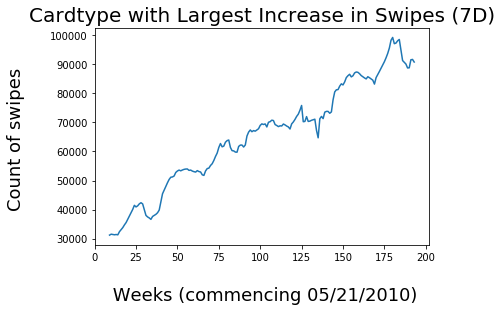

In [29]:
mta_rideType_rolling = pd.rolling_mean(dataMTA_cardtype_df, 10)

pl.plot((mta_rideType_rolling.sen))
pl.xlim(xmin = 0)
pl.title("Cardtype with Largest Increase in Swipes (7D)", fontsize=20)
pl.ylabel("Count of swipes \n", fontsize=18)
pl.xlabel("\n Weeks (commencing 05/21/2010)", fontsize=18)

### Fig. 7 Largest increase in swipe count

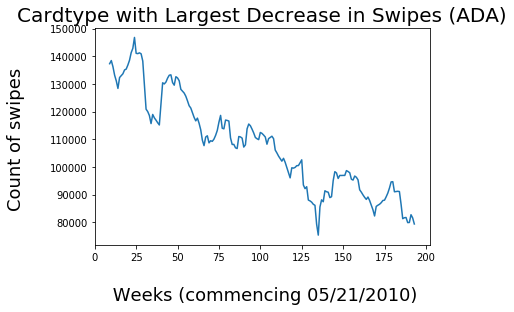

In [30]:
pl.plot((mta_rideType_rolling.month))
pl.xlim(xmin = 0)
pl.title("Cardtype with Largest Decrease in Swipes (ADA)", fontsize=20)
pl.ylabel("Count of swipes \n", fontsize=18)
pl.xlabel("\n Weeks (commencing 05/21/2010)", fontsize=18)

### Fig 8. Largest decrease in swipe count

### Task 2 Conclusion:
Cardtype with the greatest increase is 7D. It increased by 4.59% of the total share of swipes.

Cardtype with the greatest decrease is ADA. It decreased by 4.37% of the total share of swipes.

In [31]:
#################################################

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [32]:
#flattening data cube & transforming it to be 194x600
stations = np.nansum(dataMTA, axis =1)
stations.shape

(600, 194)

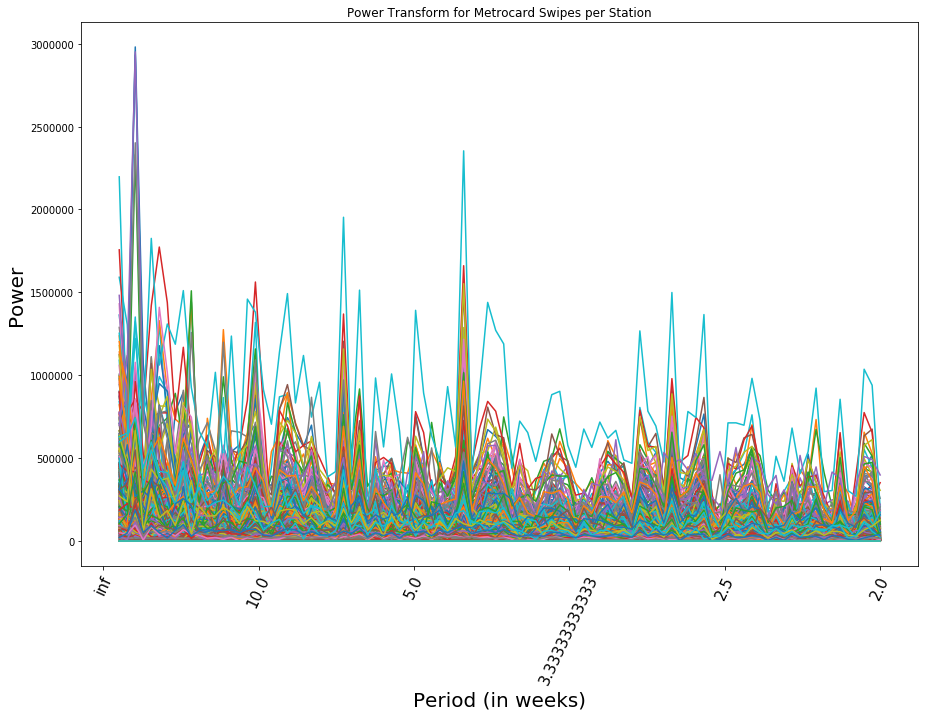

In [33]:
#power transform plot
fig = plt.figure(figsize=(15,10))
plt.title("Power Transform for Metrocard Swipes per Station")
plt.xlabel("Period (in weeks)", fontsize=20)
plt.ylabel("Power", fontsize=20)
ax = fig.add_subplot(111)
N = 194

x = np.fft.rfftfreq(N, 1.0)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    plt.plot(x[2:], f[2:], '-')

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=65, fontsize=15);

### Fig 9. Power transform for trip counts from all stations

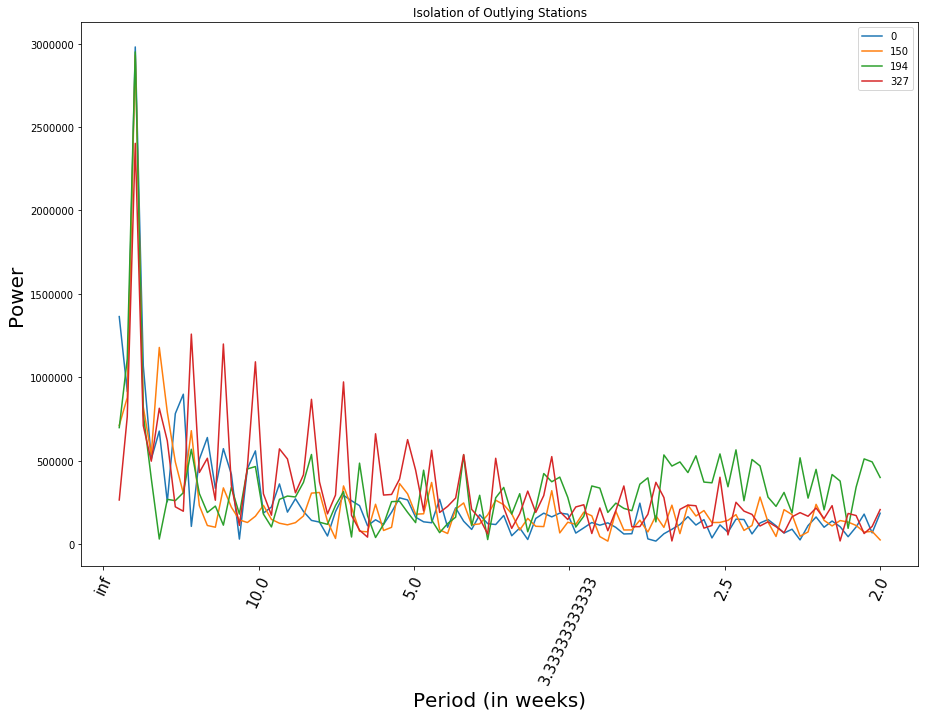

In [34]:
#Isolate 4 outliers
fig = plt.figure(figsize=(15,10))
plt.title("Isolation of Outlying Stations")
plt.xlabel("Period (in weeks)", fontsize=20)
plt.ylabel("Power", fontsize=20)
ax = fig.add_subplot(111)
N = 194

x = np.fft.rfftfreq(N, 1.0)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    if f[2:].max() > 2400000:
        plt.plot(x[2:], f[2:], '-', label=i)
        plt.legend()

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=65, fontsize=15);

### Fig 10. Power transform for trip counts for 4 outlier stations. They are stations numbers: 0, 150, 194, and 327.

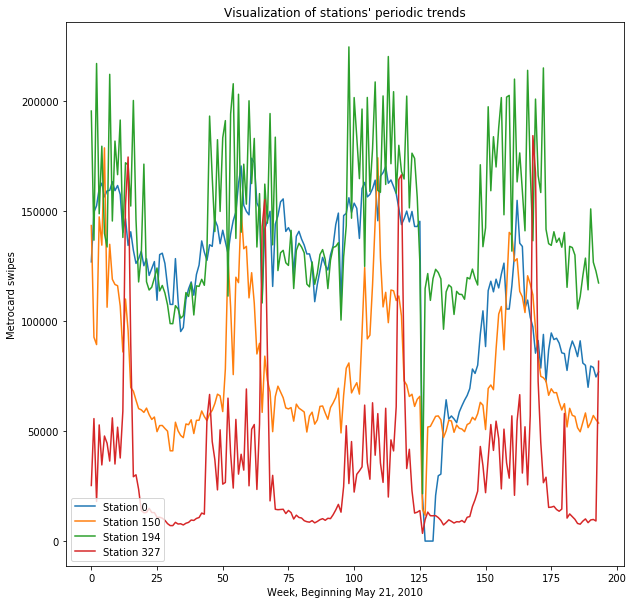

In [35]:
#plot periodicity for swipes at 4 outlier stations
fig = figsize(10,10)
plt.title("Visualization of stations' periodic trends")
plt.xlabel("Week, Beginning May 21, 2010")
plt.ylabel("Metrocard swipes")
plt.plot(stations[0], label='Station 0')
plt.plot(stations[150], label='Station 150')
plt.plot(stations[194], label='Station 194')
plt.plot(stations[327], label='Station 327')
plt.legend(loc='lower left');

### Fig 11. Periodic trends of 4 outlying stations.



### Task 3 Conclusion: 

These 4 stations illustrate a clear periodicity. There is a clear increase in riderships at certain points of the year, and a relavtive decrease at other points in the year.

Those peak periods coincide with warmer months (Apr - Sept). Larger spikes towards the end of the 'peak season' could be attribued to communiting patterns on Labor Day Weekend.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.


## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```

In [36]:
#after reading the datacube you should see:
mtaRides.shape


NameError: name 'mtaRides' is not defined

ride types list

In [ ]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [ ]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [ ]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRide.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mtaRides, axis=1)
print (mta_allsum.shape)



## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

In [ ]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

In [ ]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 

...
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

In [ ]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space